In [ ]:
# Data Analysis: ChickWeight

## Objective
#The goal of this project is to examine the impact of different diets on the growth rate of chicks over time.  
#The analysis aims to identify which diets support faster weight gain during the first days of life and which diets are more effective in the long term.

## Scope of Work
#1. Exploratory Data Analysis (EDA) – descriptive statistics and visualizations.  
#2. Comparison of weight distributions across different diets.  
#3. Statistical modeling – ANOVA and post-hoc tests (Tukey HSD) to determine which diets differ significantly from each other.  
#4. Interpretation of results and conclusions.

## Data Source
#The dataset comes from **ChickWeight**, a classical educational dataset from https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/ChickWeight.csv 
#It contains information about chick weights (`weight`) measured at different time points (`Time`), categorized by individual chicks (`Chick`) and diet type (`Diet`). 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [5]:
url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/ChickWeight.csv"
data=pd.read_csv(url,index_col=0)
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 578 entries, 1 to 578
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   weight  578 non-null    int64
 1   Time    578 non-null    int64
 2   Chick   578 non-null    int64
 3   Diet    578 non-null    int64
dtypes: int64(4)
memory usage: 22.6 KB


,weight,Time,Chick,Diet
count,578.000000,578.000000,578.000000,578.000000
mean,121.818339,10.717993,25.750865,2.235294
std,71.071960,6.758400,14.568795,1.162678
min,35.000000,0.000000,1.000000,1.000000
25%,63.000000,4.000000,13.000000,1.000000
50%,103.000000,10.000000,26.000000,2.000000
75%,163.750000,16.000000,38.000000,3.000000
max,373.000000,21.000000,50.000000,4.000000


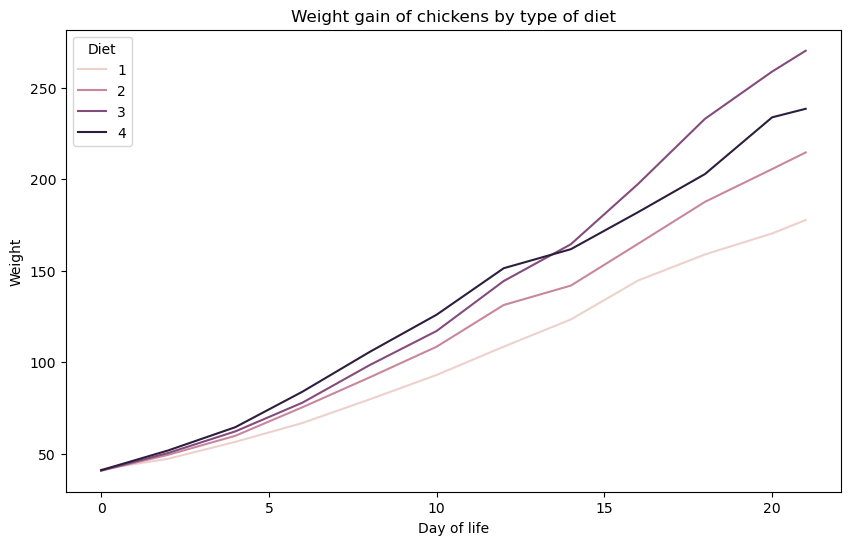

In [8]:
plt.figure(figsize=(10,6))
sns.lineplot(data,x='Time',y='weight',hue='Diet',errorbar=None)
plt.title('Weight gain of chickens by type of diet')
plt.xlabel('Day of life')
plt.ylabel('Weight')
plt.show()



In [34]:
try:
    data = sns.load_dataset("chickweight")
except:
    # Jeśli seaborn nie ma tego zbioru, ładujemy z R datasets przez statsmodels
    from statsmodels.datasets import get_rdataset
    data = get_rdataset("ChickWeight", "datasets").data


In [35]:
data.columns = [col.lower() for col in data.columns]

C:\Users\kacpe\AppData\Local\Temp\ipykernel_20688\3876252221.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="diet", y="weight", data=data, palette="Set2")


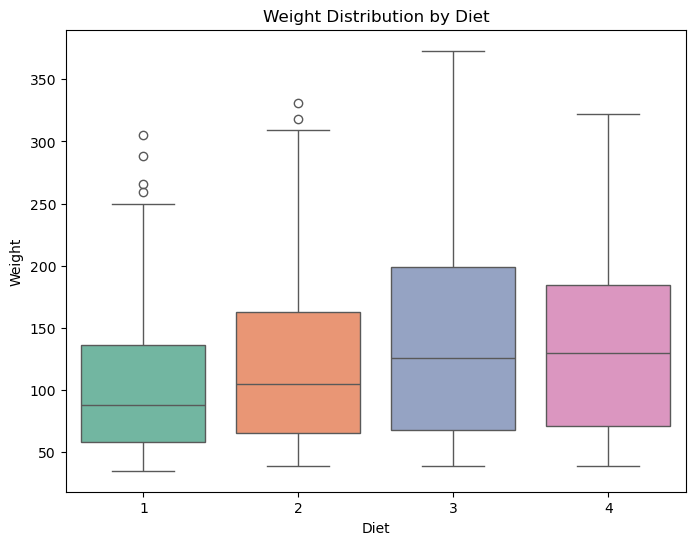

In [36]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="diet", y="weight", data=data, palette="Set2")
plt.title("Weight Distribution by Diet")
plt.xlabel("Diet")
plt.ylabel("Weight")
plt.show()

In [37]:
#ANOVA
model = ols('weight ~ C(diet)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Results:\n")
print(anova_table)

ANOVA Results:

                sum_sq     df         F        PR(>F)
C(diet)   1.558627e+05    3.0  10.81009  6.433247e-07
Residual  2.758693e+06  574.0       NaN           NaN


In [ ]:
#F=10.81, p=6.43e-07 statistically significant difference in average weight between diet groups.

In [38]:
# Post-hoc Tukey test
tukey = pairwise_tukeyhsd(endog=data['weight'], groups=data['diet'], alpha=0.05)
print("Tukey HSD Post-hoc Test:")
print(tukey)

Tukey HSD Post-hoc Test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  19.9712 0.0552  -0.2998 40.2422  False
     1      3  40.3045    0.0  20.0335 60.5756   True
     1      4  32.6173 0.0003  12.2354 52.9991   True
     2      3  20.3333 0.1058  -2.7268 43.3935  False
     2      4   12.646 0.4954 -10.5116 35.8037  False
     3      4  -7.6873 0.8278  -30.845 15.4704  False
-----------------------------------------------------


In [ ]:
#The difference in mean weight between Diet 2 and Diet 1 was not statistically significant (p = 0.055), though it was very close to the significance threshold.
#The difference between Diet 3 and Diet 2 was not statistically significant (p = 0.106).
#The difference between Diet 4 and Diet 2 was not statistically significant (p = 0.495).
#The difference between Diet 4 and Diet 3 was not statistically significant (p = 0.828).

In [41]:
#One_hot for Diet 
data_encoded=pd.get_dummies(data,columns=['diet'],drop_first=True)
X = data_encoded[['time', 'diet_2', 'diet_3', 'diet_4']]
y = data_encoded['weight']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)


In [42]:
model=RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(X_train,y_train)
y_pred =model.predict(X_test)

In [43]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 38.37
R²: 0.72


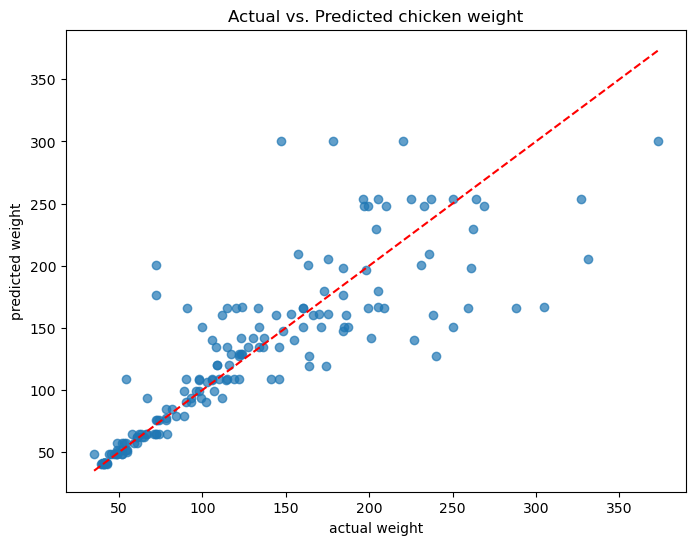

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("actual weight")
plt.ylabel("predicted weight")
plt.title("Actual vs. Predicted chicken weight")
plt.show()

In [45]:
#simulation
diet_cols = ['Diet_2', 'Diet_3', 'Diet_4']
days = range(0, 22)
rows = []
for diet_name in ['Diet_1', 'Diet_2', 'Diet_3', 'Diet_4']:
    for day in days:
        row = {'Time': day}
        for col in diet_cols:
            row[col] = 1 if col == diet_name else 0
        row['Diet'] = diet_name
        row['Day'] = day
        rows.append(row)


sim_data = pd.DataFrame(rows)
sim_data.head()


,Time,Diet_2,Diet_3,Diet_4,Diet,Day
0,0,0,0,0,Diet_1,0
1,1,0,0,0,Diet_1,1
2,2,0,0,0,Diet_1,2
3,3,0,0,0,Diet_1,3
4,4,0,0,0,Diet_1,4


In [54]:
sim_data.rename(columns={
    'Time': 'time',
    'Diet_2': 'diet_2',
    'Diet_3': 'diet_3',
    'Diet_4': 'diet_4'
}, inplace=True)
X_sim = sim_data[['time', 'diet_2', 'diet_3', 'diet_4']]  
sim_data['Predicted_Weight'] = model.predict(X_sim)


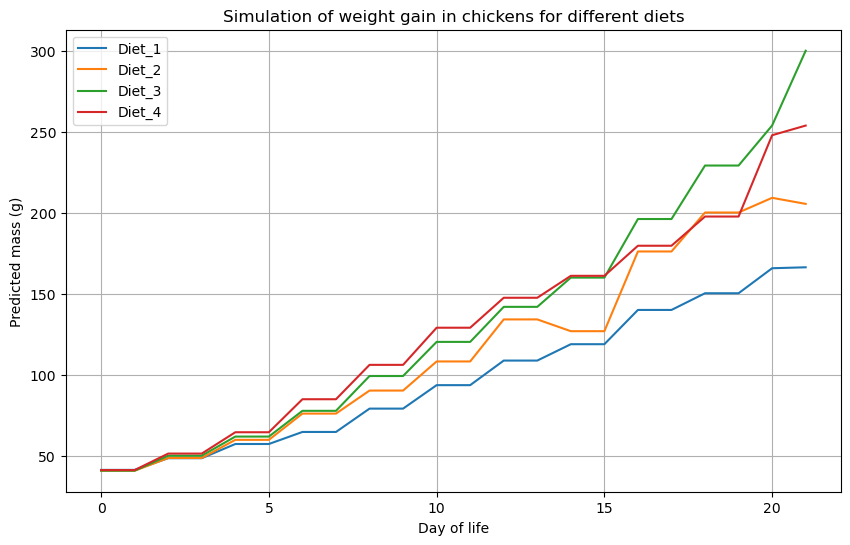

In [55]:
plt.figure(figsize=(10,6))

for diet_name in sim_data['Diet'].unique():
    subset = sim_data[sim_data['Diet'] == diet_name]
    plt.plot(subset['Day'], subset['Predicted_Weight'], label=diet_name)

plt.xlabel("Day of life")
plt.ylabel("Predicted mass (g)")
plt.title("Simulation of weight gain in chickens for different diets")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Chicks show systematic growth over time, but the growth rate varies depending on the diet.

#Up to day 14, the fastest weight gain was observed in chicks fed with Diet 4.

#After day 14, Diet 3 proved to be the most optimal, allowing for further intensive weight gain.

#Diet 1 was the least effective – chicks on this diet reached the lowest weight values.

#The results indicate that the effect of diet on weight gain is not constant over time – different diets may be more effective at different stages of growth.